In [1]:
#Define showcode button action
from IPython.display import HTML
showcode='''
<style>
.button {
    background-color: #e7e7e7;
    color: black; /* Green */
    border: none;
    padding: 5px;
    text-align: center;
    text-decoration: none;
    display: inline-block;
    font-size: 10px;
    margin: 2px 2px;
    cursor: pointer;
}
.button5 {border-radius: 50%;}
</style>
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code" class="button button5"></form>

'''

In [15]:
#Import moudles
%matplotlib inline
import mpld3
mpld3.enable_notebook()
from collections import OrderedDict
import pandas as pd
import numpy as np
import xarray as xr
import glob
from netCDF4 import Dataset as nc, num2date, MFDataset as mc, date2num
import os
import pytz
from matplotlib import pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sns
import cufflinks as cf
cf.set_config_file(offline=False, world_readable=True, theme='ggplot')
sns.set_style("whitegrid")
from DataFrame import *
from datetime import datetime
from astropy.stats import LombScargle
import astropy.units as u
from scipy import signal
import matplotlib, sys
from mpl_toolkits.basemap import Basemap, cm as colmap
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [30.0,30.0]
from collections import namedtuple
timezone = pytz.timezone('Australia/Darwin')
utc = pytz.UTC
from matplotlib import animation, rc
from matplotlib.colors import LightSource
from matplotlib.colorbar import cm as colmap2
from matplotlib.patches import Polygon

from matplotlib import animation, rc
from matplotlib.colors import LightSource
from matplotlib.colorbar import cm as colmap2
from matplotlib.patches import Polygon
import palettable as colortable
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 24}

matplotlib.rc('font', **font)
from palettable.mycarta import LinearL_20, CubeYF_20
from palettable.colorbrewer.qualitative import Paired_12
from brewer2mpl import qualitative
np.warnings.filterwarnings('ignore')
from plotly import tools
from tint.visualization import plot_traj, get_plotly_traj

# Storm Track Analysis

In [3]:
HTML(showcode)

In [5]:
# Define some paths
CPOLF = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_TIWI_1998-2017-old.nc')
WOHF = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_WOH.nc')
CMORPHF = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'UM', 'CMORPH_V1_WOH.nc')
WOHFv1 = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_WOHv1.nc')
WOHFv2 = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_WOHv2.nc')
BurstF = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_burst-cmorph.pkl')
PercF = os.path.join(os.environ['HOME'],'Data','Extremes','CPOL','CPOL_TIWI_Percentiles-old.hdf5')
extremeTS = os.path.join(os.environ['HOME'],'Data','Extremes','CPOL','CPOL_TIWI_TS_extrme.pkl')
percf =  os.path.join(os.environ['HOME'],'Data','Extremes','CPOL', 'Periods.npz')
outdir = os.path.join(os.getenv('HOME'),'Data','Extremes','UM', 'Plot', 'Week_of_Hector')
geodataf = os.path.join(os.getenv('HOME'), 'Data', 'Extremes', 'UM')
trackfile = 'tint_tracks_2006_11_10_00-2006_11_18_23.pkl'
CPOL_trackfile = os.path.join(os.getenv('HOME'),'Data', 'Extremes','CPOL', 'Tracking', trackfile)
remap_res = '2.5km'
UMdir = os.path.join(os.getenv('HOME'), 'Data', 'Extremes', 'UM', 'darwin', 'RA1T')

In [6]:
# Define the function that creates the average track information
def get_mean(data_file, res=2.5):
    if isinstance(data_file, str):
        dataset = pd.read_pickle(data_file)
    else:
        dataset = data_file
    dataset = dataset[dataset.isolated][['max', 'mean', 'area','time']]
    uid = np.array(dataset.index.get_level_values('uid')).astype('i')
    uid.sort()
    columns=['avg_mean','avg_area', 'avg_max', 'max_mean', 'max_area', 'max_max',
             'std_mean', 'std_area', 'std_max','dur']
    values=np.empty((1,len(columns)))
    index = []
    for nn, idx in enumerate(uid):
        df = pd.DataFrame(dataset.xs(str(idx), level='uid').values, columns=dataset.columns)
        if len(df):
            index.append(idx)
            mean = df[['mean','area','max']].mean().values
            Max = df[['mean','area','max']].max().values
            std = df[['mean', 'area', 'max']].std().values
            dur = np.array([(df['time'].max() - df['time'].min()).total_seconds()/60.]).round(0)
            values= np.append(values, np.r_[mean, Max, std, dur][np.newaxis],axis=0)
    out = pd.DataFrame(values[1:,], index=index, columns=columns)
    for area in ('avg_area', 'max_area'):
        out[area] = out[area] * res**2
    out = out.loc[out.dur > 0]
    out.index=np.arange(len(out))
    return xr.Dataset(out.loc[out.dur > 0])

In [7]:
# Define our ensemble member
ensembles = ('20061109T1200Z', '20061109T1800Z', '20061110T0000Z',
             '20061110T0600Z', '20061110T1200Z', '20061110T1800Z',
             '20061111T0000Z', '20061111T1200Z')

In [8]:
#Create the named-tuple containing the avg. track data
Simulation = namedtuple('Simulation', 'dataset percentiles num resolution')
UM133 = Simulation(dataset={}, percentiles={}, num={}, resolution='1p33km')
UM044 = Simulation(dataset={}, percentiles={}, num={}, resolution='0p44km')
UM044_t = Simulation(dataset={}, percentiles={}, num={}, resolution='0p44km')
UM133_t = Simulation(dataset={}, percentiles={}, num={}, resolution='1p33km')
CPOL_t = Simulation(dataset={}, percentiles={}, num={}, resolution='2.5km')

CPOL_t = Simulation(dataset={'obs': pd.read_pickle(CPOL_trackfile)}, percentiles={}, num={}, resolution='2.5km')
OBS = Simulation(dataset=get_mean(CPOL_t.dataset['obs']), percentiles={}, num={}, resolution='2.5km')
p1 = np.percentile(OBS.dataset['avg_mean'],list(np.arange(0,99))+[99, 99.9, 99.99, 99.999, 100])
p2 = np.percentile(OBS.dataset['avg_max'],list(np.arange(0,99))+[99, 99.9, 99.99, 99.999, 100])
CPOL_t.percentiles['obs'] = dict(mean=p1, max=p2)
OBS.num['obs'] = len(OBS.dataset)
CPOL_t.num['obs'] = len(CPOL_t.dataset['obs'])
for ens in ensembles:
        for mean, tracks in ((UM133, UM133_t), (UM044, UM044_t)):
            track_f = glob.glob(os.path.join(UMdir, ens, 'darwin', mean.resolution, 'Tracking', '*.pkl'))[0]
            tracks.dataset[ens] = pd.read_pickle(track_f)
            mean.dataset[ens] = get_mean(tracks.dataset[ens])
            p1 = np.percentile(mean.dataset[ens]['avg_mean'],list(np.arange(0,99))+[99, 99.9, 99.99, 99.999, 100])
            p2 = np.percentile(mean.dataset[ens]['avg_max'],list(np.arange(0,99))+[99, 99.9, 99.99, 99.999, 100])
            tracks.percentiles[ens] = dict(max=p2, mean=p1)
            tracks.num[ens] = len(tracks.dataset[ens])
            mean.num[ens] = len(mean.dataset[ens])

In [9]:
#Create tracking info ensemble
UM133_ens = xr.concat(UM133.dataset.values(), dim='ens')
UM044_ens = xr.concat(UM044.dataset.values(), dim='ens')
CPOL = OBS.dataset

In [10]:
#Define some functions
def get_quant(df, **kwargs):
    try:
        quant = kwargs['quant']
    except KeyError:
        quant={1:(0,0.2), 2:(0.2,0.4), 3:(0.4, 0.6), 4:(0.6,0.8), 5:(0.8,1)}
    try:
        rain = kwargs['rain']
    except KeyError:
        rain='avg_mean'
    for n, q in quant.items():
        Q = df[rain].quantile(q)
        df.quant.loc[(df[rain]>= Q[q[0]]) & (df[rain]<Q[q[1]]) ] = int(n)
    return df
        
        
def ravel(ens_data, run='Cpol', **kwargs):
    pdf = {}
    for var in dict(ens_data.variables).keys():
        if not var.startswith('dim') :
            pdf[var] = ens_data[var].values.ravel()
            pdf[var] = pdf[var][pdf[var] != np.nan]
    df = pd.DataFrame(pdf).dropna()
    run_n = [run for i in range(len(df))]
    df['run'] = run_n
    df['quant'] = np.zeros(len(df), dtype='i')
    df.index = np.arange(len(df))+1
    return get_quant(df, **kwargs)
UM133_pdf, UM044_pdf, CPOL_pdf = ravel(UM133_ens, 'UM 1.33km'), ravel(UM044_ens, 'UM 0.44km'), ravel(CPOL, 'Cpol')
def matplotlib_to_plotly(cmap, pl_entries, rgb=True):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []
    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        if rgb:
            pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])
        else:
            pl_colorscale.append(tuple(np.array(C)/255))

    return pl_colorscale

The tracking algorithm is a fork of the Tint (Tint is not Titan) tracking algorithm ([http://openradarscience.org/TINT/](http://openradarscience.org/TINT/)). The framework has been modified that it can be also applied to model output data that is not not stored in [Py-ART](http://arm-doe.github.io/pyart) radar data container.

- The analysis is based averages of one week worth of strome cell tracking:

### 1. Median of strom area, duration, avg., max. rain-rates and # of storm cells

In [579]:
#Plot the Medians
um044_m =np.array(list(UM044_t.num.values())).mean(dtype='i')
um133_m =np.array(list(UM133_t.num.values())).mean(dtype='i')
cpol_m =np.array(list(CPOL_t.num.values())).mean(dtype='i')
var=['avg_area','dur', 'avg_mean', 'max_mean']
names=['area', 'duration', 'avg-rain', 'max-rain', '# cells']
#print(CPOL_pdf[var].median())
medians = pd.DataFrame({'a': list(CPOL_pdf[var].median().values)+[int(cpol_m)],
                        'b': list(UM044_pdf[var].median().values)+[int(um044_m)],
                        'c': list(UM133_pdf[var].median().values)+[int(um133_m)]} )
                       #index=('Area','Duration', 'Mean-Rain', 'Max-Rain'))
medians.index=names
medians.columns=['Cpol', 'UM 1.33km', 'UM 0.44km']
#print('Medians:')
                 
medians.round(2)

Cpol  UM 1.33km  UM 0.44km
area       93.12      46.25      65.62
duration   38.00      30.00      40.00
avg-rain    4.15       5.23       4.33
max-rain    5.49       7.33       6.15
# cells   638.00     475.00     475.00

### 2. 2D-Histograms (storm area vs duration):

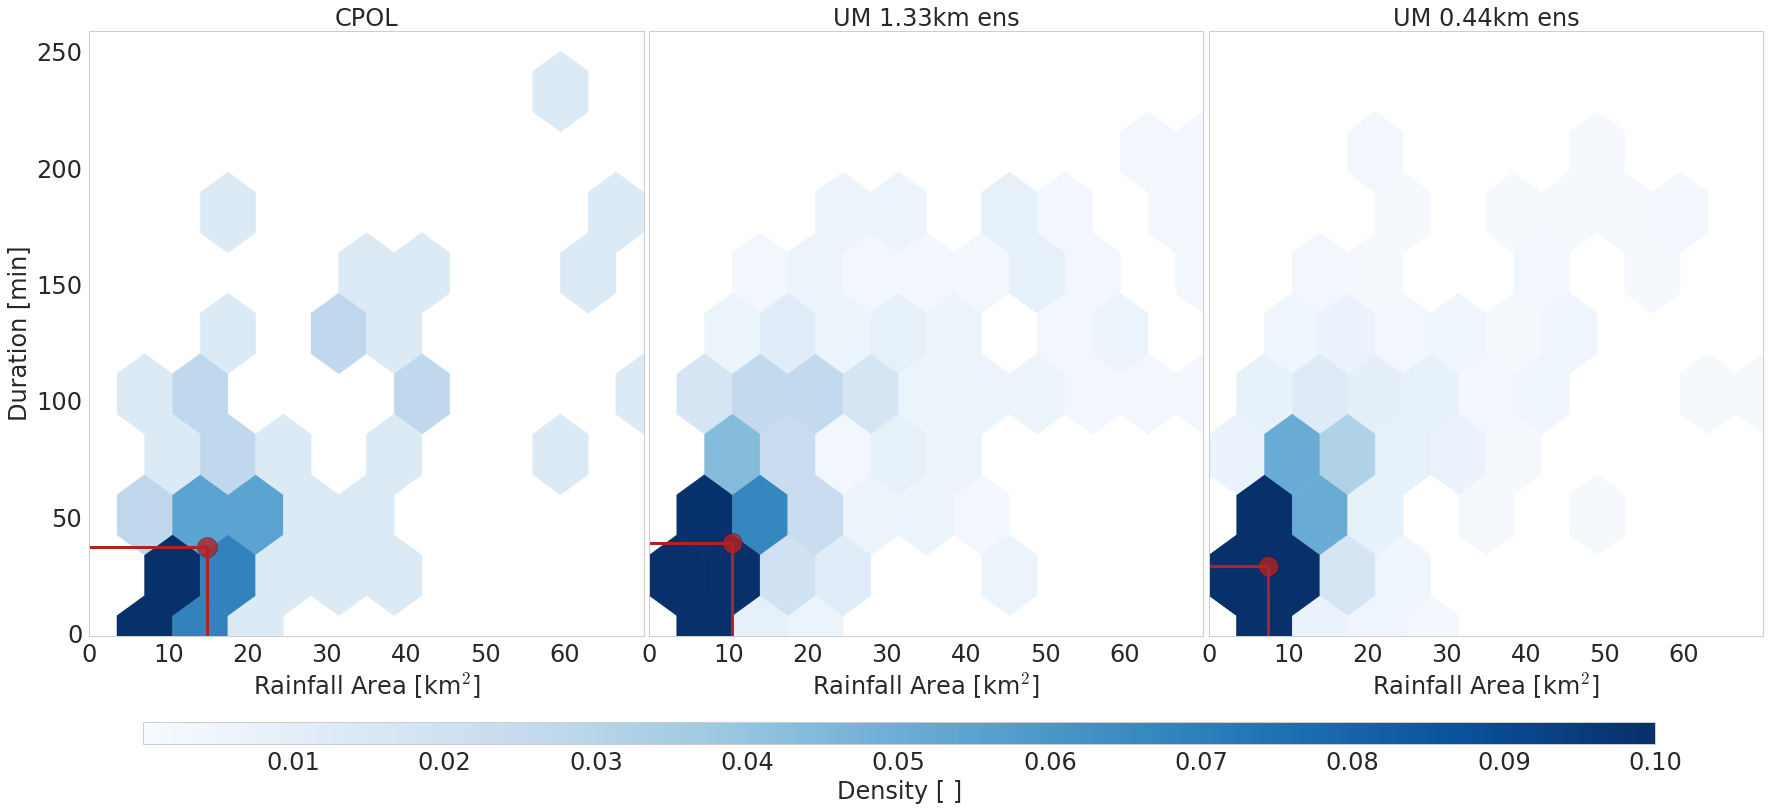

In [507]:
#Create Hex-Bin plot
var=['avg_area','dur', 'max_mean', 'avg_mean']
medians = pd.DataFrame({'CPOL':CPOL_pdf[var].median(),
                        'UM 1.33km':UM133_pdf[var].median(),
                        'UM 0.44km':UM044_pdf[var].median()})
medians.loc['avg_area'] /= 2.5**2
histdata =  [UM044_pdf[var].dropna(), UM133_pdf[var].dropna(), CPOL_pdf[var].dropna()][::-1]
titles = ['UM 0.44km ens', 'UM 1.33km ens', 'CPOL'][::-1]
fig = plt.figure()
colm = colmap2.Blues
colm.set_under('w', alpha=0)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
fig.subplots_adjust(bottom=0.07, right=0.9, top=0.35, wspace=0.01)
cbar_ax = fig.add_axes([0.15, 0.02, 0.7, 0.01])
hexbin_data = []
gridsize = 10
vmin=0.0001
vmax=0.1
nticks=10
YMax, XMax = 260, 70
for i, ax in enumerate((ax1, ax2, ax3)):
    data = histdata[i][var[:2]]
    data[var[0]] /= 2.5**2
    #data = data.loc[(data[var[0]] <= XMax) & (data[var[1]] <=YMax)]
    X = data[var[0]].values
    Y = data[var[1]].values
    ax.set_ylim(0,YMax)
    ax.set_xlim(0,XMax)
    hb =  ax.hexbin(X, Y,  gridsize=gridsize, extent=(0,XMax,0,YMax))
    hexbin_data.append(np.ones_like(Y, dtype=np.float) / hb.get_array().sum())
    
plt.cla()
medians = OrderedDict()

for i, ax in enumerate((ax1, ax2, ax3)):
    data = histdata[i][var[:2]]
    data[var[0]] /= 2.5**2
    #data = data.loc[(data[var[0]] <= XMax) & (data[var[1]] <=YMax)]
    X = data[var[0]].values
    Y = data[var[1]].values
    ax.set_ylim(0,YMax)
    ax.set_xlim(0,XMax)
    im = ax.hexbin(X, Y,  gridsize=gridsize, cmap=colm, marginals=False, extent=(0,XMax,0,YMax),
                     vmin=vmin, vmax=vmax, C=hexbin_data[i], reduce_C_function=np.sum)
    
    ax.set_title(titles[i], fontsize=24)
    ax.grid(color='w', linestyle='', linewidth=0)
    ax.tick_params(labelsize=24)
    ax.xaxis.set_ticks(range(0,70,10))
    x, y = histdata[i][var[0]].median()/2.5**2, histdata[i][var[1]].median()
    z, zz=  histdata[i][var[2]].median(), histdata[i][var[-1]].median()
    sx, sy = histdata[i][var[0]].std(), histdata[i][var[1]].std()
    medians[titles[i]] = '%2.1f km^2, %2i min (max: %2.1f mm/h, mean: %2.1f mm/h);'%(x,y, z, zz)
    ax.hlines(y*np.ones_like(histdata[i][var[0]]),0,x, 'firebrick', lw=3)
    ax.vlines(x*np.ones_like(histdata[i][var[1]]),0,y, 'firebrick', lw=3)
    ax.scatter([x], [y], marker='o', s=400, c='firebrick', alpha=0.8)
    if i == 0:
        ax.set_ylabel('Duration [min]', fontsize=24)
    ax.set_xlabel('Rainfall Area [km$^2$]', fontsize=24)
ary=im.get_array()/im.get_array().sum() * 100
im.set_array = ary
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=24)
cbar.set_label('Density [ ]',size=24)
#cbar.set_ticks(np.linspace(vmin, vmax, nticks).round(2))
#cbar.set_ticklabels(np.linspace(vmin, vmax, nticks).round(2))
#print('Medians:')
#medians
#print(' '.join(['%s: %s'%(k, v) for (k,v) in medians.items()]))

In [11]:
colm = matplotlib_to_plotly(CubeYF_20.get_mpl_colormap(N=8, gamma=2.0),8, rgb=False)

### 3. Storm tracks above the 80th percentiles
* marks start of track, colors for different ensemble member

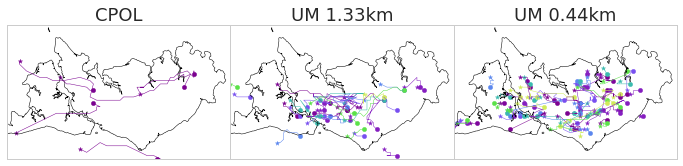

In [27]:
#Plot the tracks
fig = plt.figure(figsize=(10,6))
fig.subplots_adjust(right=0.94, bottom=0.025, top=0.9,left=0.01, hspace=0, wspace=0)
#cbar_ax = fig.add_axes([0.12, 0.17, 0.74, 0.02])
with nc(CPOLF) as fnc:
    lon=fnc.variables['longitude'][:]
    lat=fnc.variables['latitude'][:]
tp = 'mean'
num=80
titels = ['CPOL', 'UM 1.33km', 'UM 0.44km']
m = None
for i, tracks in enumerate((CPOL_t, UM133_t, UM044_t)):
    ax = fig.add_subplot(1,3,i+1)
    ax.set_title(titels[i], fontsize=18)
    for ii, tr in enumerate(tracks.dataset.keys()):
        if ii == 0:
            draw_map = None
        else:
            draw_map = m
        perc = tracks.percentiles[tr][tp][num]
        ax, m, im = plot_traj(tracks.dataset[tr], lon, lat, ax=ax, mintrace=2, thresh_val=perc, thresh='mean', 
                  color=colm[ii], draw_map=draw_map, basemap_res='f', lw=0.5, size=20)
plt.show()

In [502]:
#Plot the tracks
#fig = plt.figure(figsize=(25,15))
#fig.subplots_adjust(right=0.94, bottom=0.025, top=0.67,left=0.01, hspace=0, wspace=0)
#cbar_ax = fig.add_axes([0.12, 0.17, 0.74, 0.02])
with nc(CPOLF) as fnc:
    lon=fnc.variables['longitude'][:]
    lat=fnc.variables['latitude'][:]
tp = 'mean'
num=80
titels = ['CPOL', 'UM 1.33km', 'UM 0.44km']
data = []
layout =dict(autosize = False)
domains = [[0,.3], [0.33, 0.63], [0.66,0.99]]
ii = 0
data = []
#fig['layout'].update(height=600, width=600,
#fig = tools.make_subplots(rows=1, cols=3, subplot_titles=Titles)
for i, tracks in enumerate((CPOL_t, UM133_t, UM044_t)):
    #ax = fig.add_subplot(1,3,i+1)
    #for tr in tracks.dataset.keys():
    name = 'geo'+str(ii+1) if ii != 0 else 'geo'
    layout[name] = dict(
        domain = dict(x=domains[i], y=[0,1]),
        resolution=50,
        lonaxis =  dict(range = [min(lon), max(lon)]),
        lataxis = dict(range = [min(lat), max(lat)]),
        projection=dict( type='azimuthal equal area', scale=1 ),
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)')
    if ii == 0 or ii == 1 or ii == 15:
         text = [titels[i]]
    else:
        text = None
            
    perc = tracks.percentiles[tr][tp][num]
    data += get_plotly_traj(tracks.dataset[tr], thresh_val=perc, thresh='mean',
                                    geo=name, mintrace=2, text=text,showlegend = False)
    ii += 1
    #plot_traj(tracks.dataset[tr], lon, lat, ax=ax, mintrace=2, thresh_val=perc, thresh='mean')
fig = dict( data=data, layout=layout )
py.iplot( fig, filename='storm-tracks' )

KeyError: '20061110T0600Z'

In [495]:
df_stack = pd.concat([CPOL_pdf, UM133_pdf, UM044_pdf], ignore_index=True)
df_stack['avg_area'] /= 2.5**2
df_stack['avg_area'].loc[(df_stack['quant']==3) & (df_stack['run']=='Cpol')] /= 1.5
df_stack['dur'].loc[(df_stack['quant']==3) & (df_stack['run']=='Cpol')] /= 2
#df_stack['quant'] = df_stack['quant'].astype('i')


###  4. Classification of strom area, rain-rate and duration by rain-rate quintiles

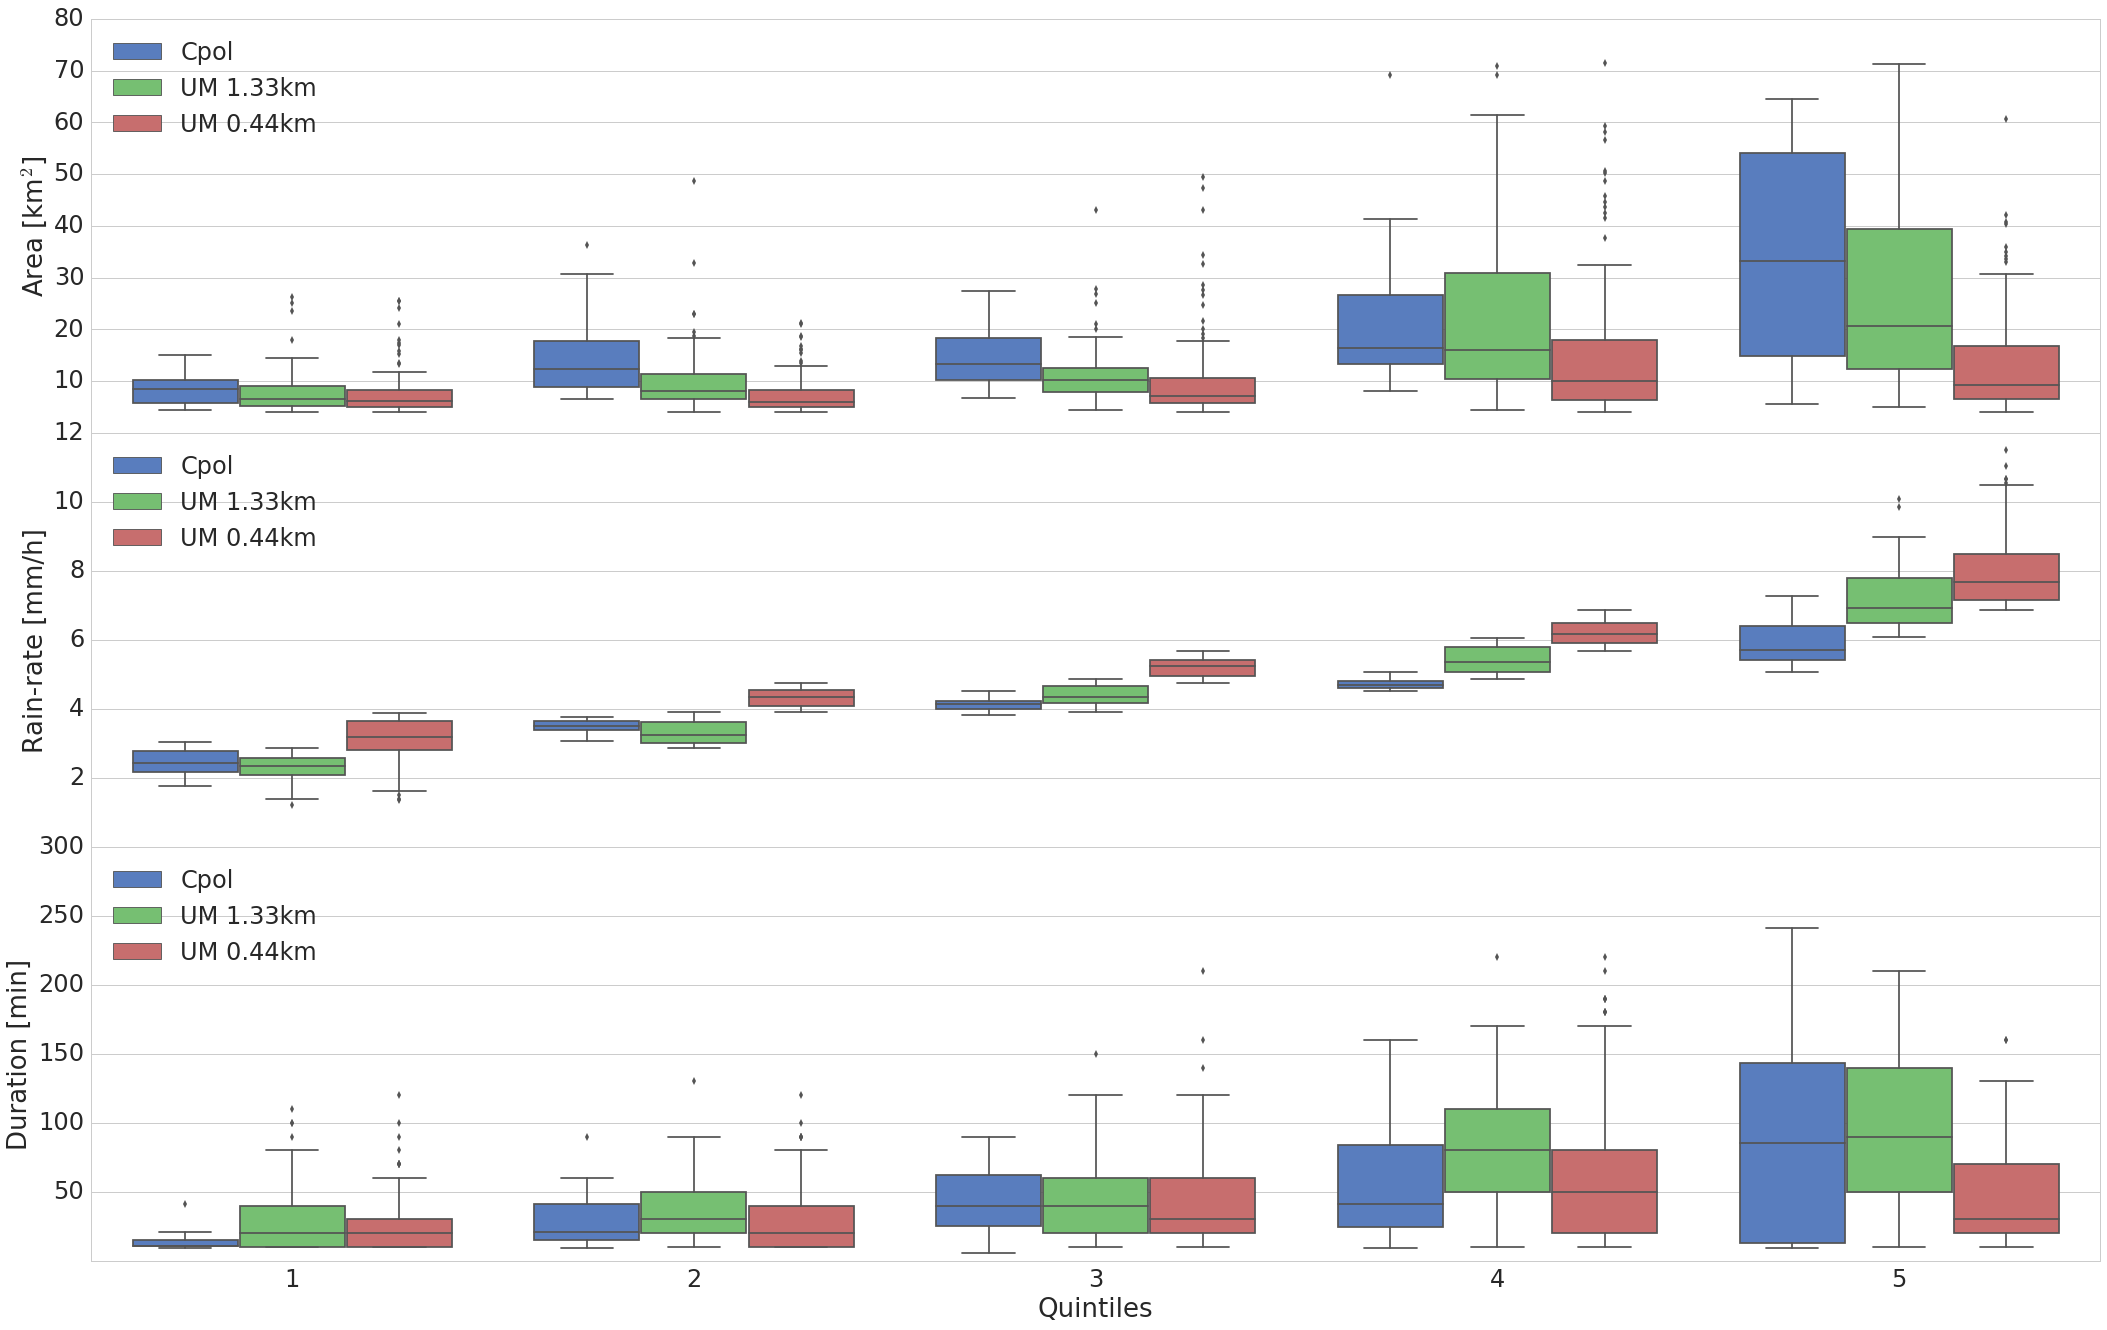

In [516]:
variables=dict(dur=('Duration [min]',300), avg_area=('Area [km$^2$]', 80), avg_mean=('Rain-rate [mm/h]',12))
fig = plt.figure()
fig.subplots_adjust(right=0.94, bottom=0.025, top=0.6,left=0.01, hspace=0, wspace=0)
i = 0
for y, prop in variables.items():
    label, ylim = prop
    npl = len(list(variables.keys()))
    i += 1
    ax = fig.add_subplot(npl,1,i)
    ax = sns.boxplot(x="quant", y=y, hue="run", data=df_stack, palette="muted", ax=ax)
    #ax = sns.stripplot(x="quant", y=y, hue="run", data=df_stack, jitter=True, palette="Set2", dodge=True)
    ax.legend(loc=0, fontsize=24)
    ax.tick_params(labelsize=24)
    ax.set_xlim(0.5,5.5)
    ax.set_ylim(0,ylim)
    ax.yaxis.set_ticks(ax.yaxis.get_ticklocs()[1:])
    ax.set_xlabel('Quintiles', fontsize=26)
    ax.set_ylabel(label, fontsize=26)

### 5. Stormtrack Percentiles vs Rain-rate

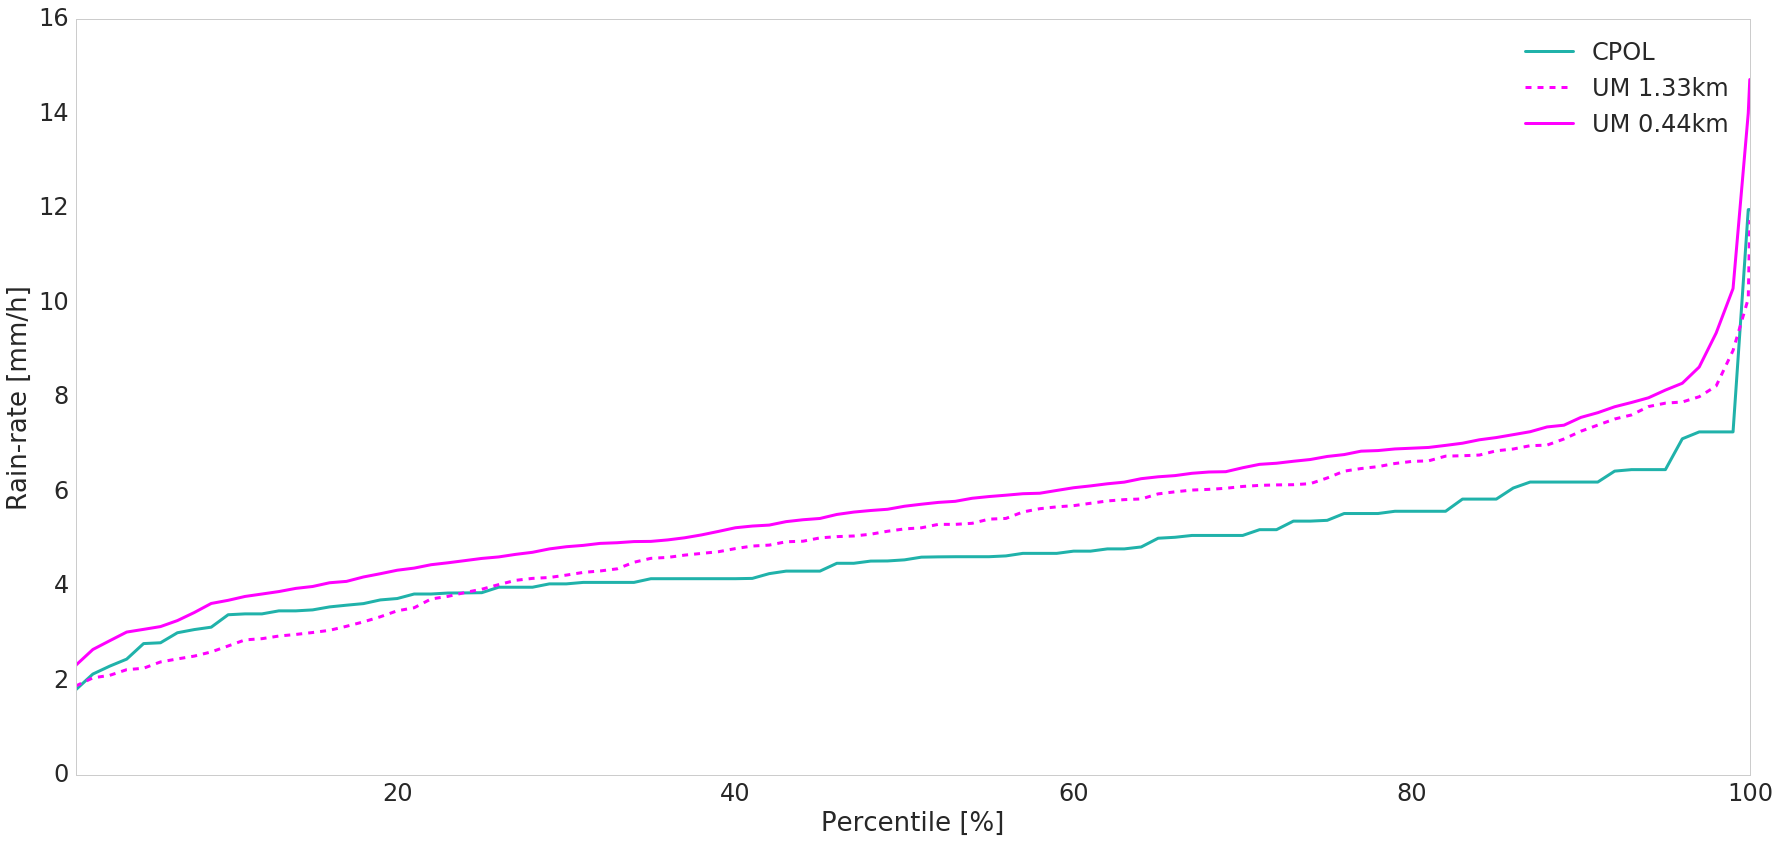

In [46]:
P = list(np.arange(0,99))+[99, 99.9, 99.99, 99.999, 100]
PERC = pd.DataFrame({'Obs':np.percentile(CPOL_pdf['avg_mean'].values, P), 
                     'UM 1.33km': np.percentile(UM133_pdf['avg_mean'].values, P),
                      'UM 0.44km': np.percentile(UM044_pdf['avg_mean'].values, P)},index=P)
from mpl_toolkits.axes_grid.inset_locator import inset_axes
#Plot the percentages
fig=plt.figure()
ax = fig.add_subplot(111)
plt.subplots_adjust(bottom=0.05, right=0.9, top=0.4)
ax.plot(PERC.index, PERC['Obs'].values, color='lightseagreen', linestyle='-', label='CPOL',lw=3)
ax.plot(PERC.index, PERC['UM 1.33km'].values, color='fuchsia', linestyle='--', label='UM 1.33km',lw=3)
ax.plot(PERC.index, PERC['UM 0.44km'].values, color='fuchsia', linestyle='-', label='UM 0.44km', lw=3)
ax.set_xlim(1,100)
#ax.set_ylim(10,100)
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('Percentile [%]', fontsize=26)
ax.set_ylabel('Rain-rate [mm/h]', fontsize=26)
ax.legend(loc=0, fontsize=24)
ax.tick_params(labelsize=24)
ax.grid(color='r', linestyle='-', linewidth=0)